In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
import Base.Iterators: flatten
using CSV
using DataFrames
using Distributions
using HTTP
import ForneyLab.dot2svg
@everywhere using Mamba
# using Mamba
using Plots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


# 1 ベイズ推論の考え方
## 1.4 例題 : メッセージ数に変化はあるのか？
メッセージ受信数が時間が経つにつれて変化するかどうかを調べる

In [3]:
r = HTTP.request("GET", "https://git.io/vXTVC");
count_data = CSV.read(IOBuffer(r.body), header=["messages"])
disallowmissing!(count_data)

74×1 DataFrame
│ Row │ messages │
│     │ Float64  │
├─────┼──────────┤
│ 1   │ 13.0     │
│ 2   │ 24.0     │
│ 3   │ 8.0      │
│ 4   │ 24.0     │
│ 5   │ 7.0      │
│ 6   │ 35.0     │
│ 7   │ 14.0     │
│ 8   │ 11.0     │
│ 9   │ 15.0     │
│ 10  │ 11.0     │
⋮
│ 64  │ 31.0     │
│ 65  │ 30.0     │
│ 66  │ 13.0     │
│ 67  │ 27.0     │
│ 68  │ 0.0      │
│ 69  │ 39.0     │
│ 70  │ 37.0     │
│ 71  │ 5.0      │
│ 72  │ 14.0     │
│ 73  │ 13.0     │
│ 74  │ 22.0     │

In [4]:
N = length(count_data.messages)

74

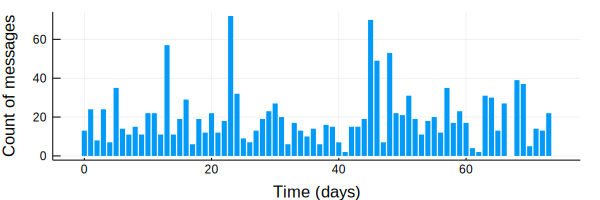

In [5]:
bar(0:N-1, count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")

$i$日目のメッセージを$C_i$とするとき、
\begin{align}
C_i \sim \text{Poisson}(\lambda)
\end{align}
とする.
### まずは一番な単純なモデル
\begin{align}
\lambda \sim \text{Exp}(\alpha)
\end{align}
のモデルを作ってみる。$\alpha$は計数データの平均の逆数とする。Distribution.jlにおけるパラメーターの取り方は、PyMCと異なることに留意。  
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Continuous-Distributions-1

In [6]:
theta = mean(count_data.messages)

19.743243243243242

In [7]:
model0 = Model(
    
    obs = Stochastic(1,
        (ls, N) ->
            UnivariateDistribution[Poisson(ls[i]) for i in 1:N],
        false
    ),
    
    ls = Logical(1, (lambda, N) -> fill(lambda, N), false),
    
    lambda = Stochastic(theta -> Exponential(theta)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
ls:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]


In [8]:
data0 = Dict{Symbol, Any}(
    :obs => count_data.messages,
    :theta => theta,
    :N => N,
)

Dict{Symbol,Any} with 3 entries:
  :N     => 74
  :obs   => [13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0,…
  :theta => 19.7432

In [9]:
inits0 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda => theta,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])

In [10]:
scheme0 = [AMWG([:lambda], 1.0)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [11]:
setsamplers!(model0, scheme0)
sim0 = mcmc(model0, data0, inits0, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [5:47:19 of 5:47:24 remaining]
      From worker 3:	Chain 2:   0% [5:56:15 of 5:56:21 remaining]
      From worker 4:	Chain 3:   0% [6:06:14 of 6:06:20 remaining]
      From worker 2:	Chain 1:  10% [0:00:56 of 0:01:03 remaining]
      From worker 3:	Chain 2:  10% [0:00:59 of 0:01:05 remaining]
      From worker 4:	Chain 3:  10% [0:01:00 of 0:01:07 remaining]
      From worker 2:	Chain 1:  20% [0:00:28 of 0:00:35 remaining]
      From worker 3:	Chain 2:  20% [0:00:29 of 0:00:36 remaining]
      From worker 4:	Chain 3:  20% [0:00:29 of 0:00:37 remaining]
      From worker 2:	Chain 1:  30% [0:00:19 of 0:00:28 remaining]
      From worker 3:	Chain 2:  30% [0:00:19 of 0:00:28 remaining]
      From worker 4:	Chain 3:  30% [0:00:20 of 0:00:28 remaining]
      From worker 2:	Chain 1:  40% [0:00:13 of 0:00:22 remaining]
      From worker 3:	Chain 2:  40% [0:00:13 of 0:00:22 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[20.3586; 19.8079; … ; 18.3749; 18.9734]

[20.2069; 19.8173; … ; 19.4639; 19.9272]

[19.8859; 20.2836; … ; 19.4911; 19.5736]

$\lambda$の平均はメッセージ数の平均とほぼ一致。

In [12]:
describe(sim0)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
          Mean       SD      Naive SE     MCSE     ESS
lambda 19.759432 0.5195765 0.005476817 0.00896106 3000

Quantiles:
         2.5%     25.0%    50.0%     75.0%     97.5%  
lambda 18.76152 19.40219 19.752745 20.110276 20.786727



In [13]:
gelmandiag(sim0, mpsrf = true, transform = true)

             PSRF 97.5%
      lambda    1     1
Multivariate    1   NaN



サンプリングの図示。サイズの変え方がわからない・・・

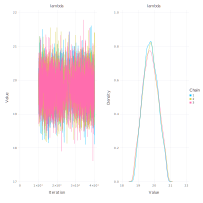

In [14]:
p0 = Mamba.plot(sim0, legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

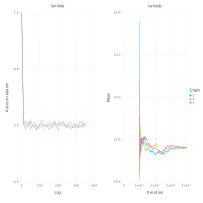

In [15]:
p0 = Mamba.plot(sim0, [:autocor, :mean], legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

### 変化はあるか？
ここで、どこかで$\lambda$が大きくなっているか調べるために、
\begin{align}
\lambda_t = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau,\\
\lambda_2 & \text{if}\ t \ge \tau. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\tau & \sim \text{DiscreteUniform}(0,N)
\end{align}
とする。

In [16]:
model1 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1, 
        (lambda1, lambda2, tau, N) -> 
            (out = fill(lambda1, N);
            i = Int64(tau.value) + 1; # Juliaは1-indexingのため
            out[i:end] .= lambda2;
            out),
        ),
    
    lambda1 = Stochastic(theta -> Exponential(theta)),
    lambda2 = Stochastic(theta -> Exponential(theta)),
    
    tau = Stochastic(N -> DiscreteUniform(0, N)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStochastic"
NaN


In [17]:
inits1 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda1 => theta,
        :lambda2 => theta,
        :tau => 1,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)

In [18]:
scheme1 = [AMWG([:lambda1, :lambda2], 1.0), DGS(:tau)]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:tau]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:tau])), Const(##238#241(Box(Symbol[:tau])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                       

In [19]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data0, inits1, 40000, burnin = 10000, thin = 3, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 4:	Chain 2:   0% [1:27:45 of 1:27:46 remaining]
      From worker 2:	Chain 3:   0% [1:30:21 of 1:30:22 remaining]
      From worker 3:	Chain 1:   0% [1:32:25 of 1:32:26 remaining]
      From worker 4:	Chain 2:  10% [0:01:59 of 0:02:12 remaining]
      From worker 3:	Chain 1:  10% [0:02:00 of 0:02:14 remaining]
      From worker 2:	Chain 3:  10% [0:02:04 of 0:02:17 remaining]
      From worker 4:	Chain 2:  20% [0:01:46 of 0:02:12 remaining]
      From worker 3:	Chain 1:  20% [0:01:46 of 0:02:12 remaining]
      From worker 2:	Chain 3:  20% [0:01:47 of 0:02:14 remaining]
      From worker 4:	Chain 2:  30% [0:01:28 of 0:02:06 remaining]
      From worker 3:	Chain 1:  30% [0:01:28 of 0:02:06 remaining]
      From worker 2:	Chain 3:  30% [0:01:30 of 0:02:08 remaining]
      From worker 3:	Chain 1:  40% [0:01:16 of 0:02:06 remaining]
      From worker 4:	Chain 2:  40% [0:01:16 of 0:02:06 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 10003:40000
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 10000

[44.0 24.5138 … 24.5138 24.5138; 45.0 22.049 … 22.049 22.049; … ; 44.0 23.0166 … 23.0166 23.0166; 44.0 23.0166 … 23.0166 23.0166]

[45.0 22.7107 … 22.7107 22.7107; 45.0 22.8928 … 22.8928 22.8928; … ; 44.0 21.978 … 21.978 21.978; 45.0 21.978 … 21.978 21.978]

[44.0 21.1396 … 21.1396 21.1396; 44.0 22.3106 … 22.3106 22.3106; … ; 45.0 23.1864 … 23.1864 23.1864; 44.0 23.1864 … 23.1864 23.1864]

In [20]:
describe(sim1)

Iterations = 10003:40000
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 10000

Empirical Posterior Estimates:
              Mean       SD       Naive SE       MCSE         ESS   
       tau 44.264600 1.42559505 0.0082306769 0.0093876339 10000.0000
   lambda2 22.701384 0.89264094 0.0051536649 0.0112542430  6291.0194
   lambda1 17.756186 0.63029038 0.0036389832 0.0073016716  7451.3808
 lambda[1] 17.756186 0.63029038 0.0036389832 0.0073016716  7451.3808
 lambda[2] 17.756345 0.63052718 0.0036403504 0.0072957902  7469.0086
 lambda[3] 17.756345 0.63052718 0.0036403504 0.0072957902  7469.0086
 lambda[4] 17.756809 0.62985614 0.0036364761 0.0072944098  7455.9402
 lambda[5] 17.756809 0.62985614 0.0036364761 0.0072944098  7455.9402
 lambda[6] 17.756936 0.62991834 0.0036368353 0.0072959040  7454.3587
 lambda[7] 17.756936 0.62991834 0.0036368353 0.0072959040  7454.3587
 lambda[8] 17.757080 0.62999429 0.0036372737 0.0072869666  7474.4573
 lambda[9] 17.757170 0.63010567 0.0036379168 0.00729

lambda[74] 20.980685 22.095237 22.691889 23.304305 24.451930



In [21]:
gelmandiag(sim1, mpsrf = true, transform = true)

              PSRF 97.5%
         tau 1.004 1.004
     lambda2 1.000 1.001
     lambda1 1.000 1.000
   lambda[1] 1.000 1.000
   lambda[2] 1.000 1.000
   lambda[3] 1.000 1.000
   lambda[4] 1.000 1.000
   lambda[5] 1.000 1.000
   lambda[6] 1.000 1.000
   lambda[7] 1.000 1.000
   lambda[8] 1.000 1.000
   lambda[9] 1.000 1.000
  lambda[10] 1.000 1.000
  lambda[11] 1.000 1.000
  lambda[12] 1.000 1.000
  lambda[13] 1.000 1.000
  lambda[14] 1.000 1.000
  lambda[15] 1.000 1.000
  lambda[16] 1.000 1.000
  lambda[17] 1.000 1.000
  lambda[18] 1.000 1.000
  lambda[19] 1.000 1.000
  lambda[20] 1.000 1.000
  lambda[21] 1.000 1.000
  lambda[22] 1.000 1.000
  lambda[23] 1.000 1.000
  lambda[24] 1.000 1.000
  lambda[25] 1.000 1.000
  lambda[26] 1.000 1.000
  lambda[27] 1.000 1.000
  lambda[28] 1.000 1.000
  lambda[29] 1.000 1.000
  lambda[30] 1.000 1.000
  lambda[31] 1.000 1.000
  lambda[32] 1.000 1.000
  lambda[33] 1.000 1.000
  lambda[34] 1.000 1.000
  lambda[35] 1.000 1.000
  lambda[36] 1.000 1.000


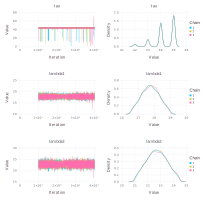

In [22]:
p1 = Mamba.plot(sim1[:, [:tau, :lambda1, :lambda2], :], legend = true)
Mamba.draw(p1, nrow = 3, ncol = 2)

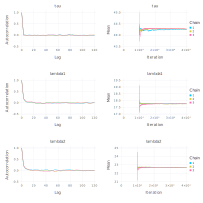

In [23]:
p1 = Mamba.plot(sim1[:, [:tau, :lambda1, :lambda2], :], [:autocor, :mean], legend = true)
Mamba.draw(p1, nrow = 3, ncol = 2)

$\tau$のヒストグラムを表示する

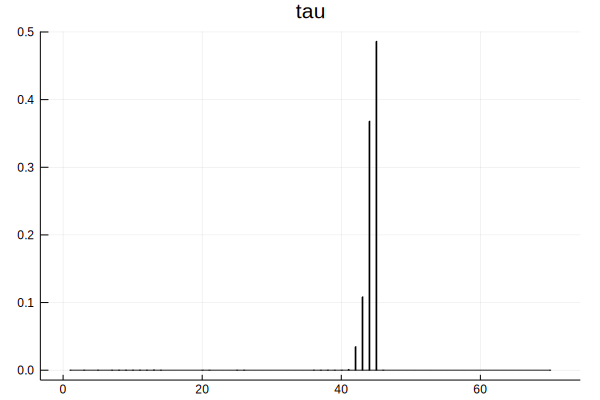

In [24]:
histogram(vec(sim1[:, :tau, :].value), normalize = :probability, title = "tau", label = "")

### 受信メッセージ数とその期待値を表示する

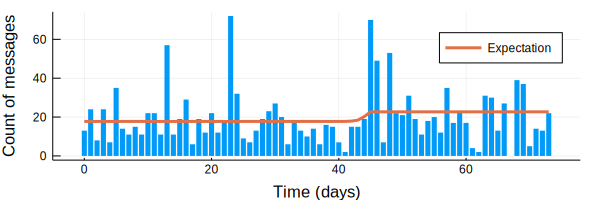

In [25]:
bar(0:N-1, count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")
plot!(0:N-1, vec(mean(sim1[:, :lambda, :].value, dims=[1, 3])), linewidth = 3, label = "Expectation")

### 実際に二つの$\lambda$は統計的に異なっているのか？
事後分布から得られたサンプル

In [26]:
lambda1_sample = sim1[:, :lambda1, :].value
lambda2_sample = sim1[:, :lambda2, :].value

10000×1×3 Array{Float64,3}:
[:, :, 1] =
 24.513775416009466
 22.049036894690804
 22.13755933156346 
 23.14133352712409 
 21.500953260888963
 22.203749436005584
 22.102171038330482
 21.538793268195036
 22.355969609304665
 22.242648474632464
 22.242648474632464
 23.34248413861875 
 23.34248413861875 
  ⋮                
 23.55399281632776 
 23.55399281632776 
 22.43671364583938 
 23.19388358131919 
 23.53612937252205 
 23.53612937252205 
 23.016614247827796
 23.016614247827796
 23.016614247827796
 23.016614247827796
 23.016614247827796
 23.016614247827796

[:, :, 2] =
 22.710732754651087
 22.892767707023427
 22.892767707023427
 22.840756547029088
 22.840756547029088
 23.154949877318767
 22.10925005981646 
 21.34839997037822 
 22.879953545832088
 22.879953545832088
 22.69777327033394 
 22.69777327033394 
 22.238231641689833
  ⋮                
 23.596880545265343
 23.596880545265343
 23.596880545265343
 23.734705543601898
 23.734705543601898
 23.734705543601898
 22.216917095183955
 22.216

$\lambda_1 < \lambda_2$となったサンプル数

In [27]:
sum(lambda1_sample .< lambda2_sample)

29997

全サンプル数

In [28]:
length(lambda1_sample)

30000

$\lambda_1$が$\lambda_2$となる確率$p(\lambda_1 < \lambda_2 \mid \text{data})$を求める。結果はほとんど1になる。

In [29]:
mean(lambda1_sample .< lambda2_sample)

0.9999

$\lambda_1$と$\lambda_2$の値が1, 2, 5, 10より大きく異なっている確率を求めよう。

In [30]:
for d in [1, 2, 5, 10]
    println("The probability the difference is larger than ", d, " : ", mean(abs.(lambda1_sample .- lambda2_sample) .> d))
end

The probability the difference is larger than 1 : 0.9995666666666667
The probability the difference is larger than 2 : 0.9959666666666667
The probability the difference is larger than 5 : 0.48246666666666665
The probability the difference is larger than 10 : 0.0


### 演習問題1. $\lambda_1$と$\lambda_2$の事後分布の平均を求める。

In [31]:
println(mean(sim1[:, :lambda1, :].value))
println(mean(sim1[:, :lambda2, :].value))

17.756186222733962
22.70138396788944


### 演習問題2. メッセージ受信数の増加数のヒストリグラムを作成し、期待値を求める。

In [32]:
relative_increase_samples = (lambda2_sample - lambda1_sample) ./ lambda1_sample

10000×1×3 Array{Float64,3}:
[:, :, 1] =
 0.2822759778362564 
 0.26215568092123365
 0.2672229814623614 
 0.28917321633613885
 0.16576104689429513
 0.23377134826935816
 0.2281270530562522 
 0.19682245952134886
 0.24222959938529173
 0.2176874761319665 
 0.2176874761319665 
 0.29790518333352883
 0.3029212665878987 
 ⋮                  
 0.389582215271759  
 0.33091274737266096
 0.2677811542719727 
 0.30561455608171095
 0.3248800268764359 
 0.3248800268764359 
 0.32665191238978863
 0.32665191238978863
 0.32665191238978863
 0.32665191238978863
 0.32665191238978863
 0.32665191238978863

[:, :, 2] =
 0.30723620366946935
 0.3639103864564809 
 0.25479240751769816
 0.2519415853933351 
 0.2519415853933351 
 0.27486553598790103
 0.2172913816327503 
 0.1567560642688269 
 0.23974279342028926
 0.23974279342028926
 0.2797064339296422 
 0.2797064339296422 
 0.2738664539260318 
 ⋮                  
 0.3567373817513776 
 0.3567373817513776 
 0.3567373817513776 
 0.3646618329102637 
 0.3646618329102637 
 0

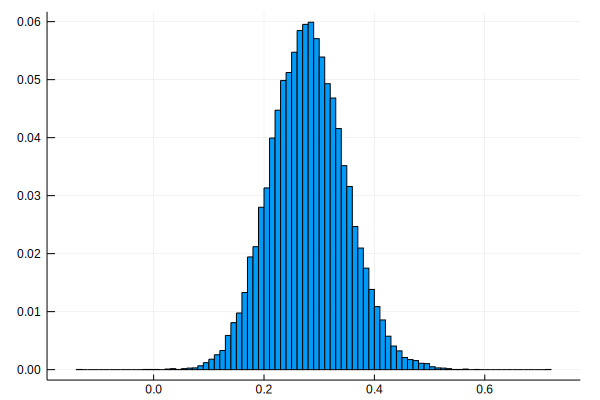

In [33]:
histogram(vec(relative_increase_samples), normalize = :probability, label = "")

In [34]:
mean(relative_increase_samples)

0.28013002199205655

### 演習問題3. $\tau$が45よりも小さいという情報が与えられた場合の$\lambda_1$の平均を求める。

In [35]:
mean(lambda1_sample[sim1[:, :tau, :].value .< 45])

17.75847076937776

### 二つの変化点への拡張
変化点が一つではなく、二つの場合の拡張を考えてみよう。
\begin{align}
\lambda_t = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau_1,\\
\lambda_2 & \text{if}\ \tau_1 \le t < \tau_2,\\
\lambda_3 & \text{if}\ t \ge \tau_2. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\lambda_3 & \sim \text{Exp}(\alpha) \\
\tau_1 & \sim \text{DiscreteUniform}(0,N-1) \\
\tau_2 & \sim \text{DiscreteUniform}(\tau_1,N)
\end{align}

In [36]:
model2 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1, 
        (lambda1, lambda2, lambda3, tau1, tau2, N) -> 
            (out = fill(lambda1, N);
            i1 = Int64(tau1.value) + 1; # Juliaは1-indexingのため
            i2 = Int64(tau2.value) + 1;
            out[i1:end] .= lambda2;
            out[i2:end] .= lambda3;
            out),
            false,
        ),
    
    lambda1 = Stochastic(theta -> Exponential(theta)),
    lambda2 = Stochastic(theta -> Exponential(theta)),
    lambda3 = Stochastic(theta -> Exponential(theta)),
    
    tau1 = Stochastic(N -> DiscreteUniform(0, N-1)),
    tau2 = Stochastic((tau1, N) -> DiscreteUniform(tau1, N)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
tau1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
tau2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
lambda3:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStocha

In [37]:
inits2 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda1 => theta,
        :lambda2 => theta,
        :lambda3 => theta,
        :tau1 => 1,
        :tau2 => N,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:tau1=>1,:tau2=>74,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda3=>19.7432,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:tau1=>1,:tau2=>74,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda3=>19.7432,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:tau1=>1,:tau2=>74,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda3=>19.7432,:lambda2=>19.7432)

In [38]:
scheme2 = [AMWG([:lambda1, :lambda2, :lambda3], 1.0), DGS([:tau1, :tau2])]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2, :lambda3]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:tau1, :tau2]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:tau1, :tau2])), Const(##238#241(Box(Symbol[:tau1, :tau2])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                     

In [39]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data0, inits2, 40000, burnin = 10000, thin = 3, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 3:	Chain 1:   0% [0:03:28 of 0:03:28 remaining]
      From worker 2:	Chain 2:   0% [0:04:32 of 0:04:32 remaining]
      From worker 4:	Chain 3:   0% [0:05:25 of 0:05:25 remaining]
      From worker 3:	Chain 1:  10% [0:02:19 of 0:02:34 remaining]
      From worker 2:	Chain 2:  10% [0:02:20 of 0:02:36 remaining]
      From worker 4:	Chain 3:  10% [0:02:20 of 0:02:36 remaining]
      From worker 3:	Chain 1:  20% [0:02:19 of 0:02:54 remaining]
      From worker 2:	Chain 2:  20% [0:02:20 of 0:02:55 remaining]
      From worker 4:	Chain 3:  20% [0:02:20 of 0:02:55 remaining]
      From worker 3:	Chain 1:  30% [0:02:13 of 0:03:09 remaining]
      From worker 2:	Chain 2:  30% [0:02:13 of 0:03:10 remaining]
      From worker 4:	Chain 3:  30% [0:02:14 of 0:03:11 remaining]
      From worker 3:	Chain 1:  40% [0:02:06 of 0:03:30 remaining]
      From worker 2:	Chain 2:  40% [0:02:07 of 0:03:31 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10003:40000
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 10000

[45.0 47.0 … 65.4853 17.717; 45.0 47.0 … 67.4136 17.717; … ; 45.0 47.0 … 53.4419 18.4503; 45.0 47.0 … 64.2069 17.7172]

[45.0 47.0 … 47.4036 17.1499; 45.0 47.0 … 60.7919 18.1629; … ; 45.0 47.0 … 56.8015 17.2679; 45.0 47.0 … 58.3949 18.5869]

[45.0 47.0 … 59.7403 17.2696; 45.0 47.0 … 66.591 17.2696; … ; 45.0 47.0 … 67.0355 17.9003; 45.0 47.0 … 65.2684 18.6848]

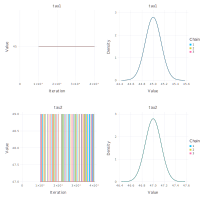

In [40]:
p2 = Mamba.plot(sim2[:, [:tau1, :tau2], :], legend = true)
Mamba.draw(p2, nrow = 2, ncol = 2)

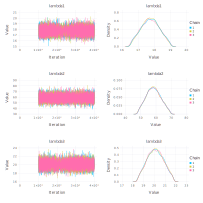

In [41]:
p2 = Mamba.plot(sim2[:, [:lambda1, :lambda2, :lambda3], :], legend = true)
Mamba.draw(p2, nrow = 3, ncol = 2)

### 変化点の個数をモデリングする

In [73]:
model3 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1,
        (lambda_i, s_i) ->
            collect(Base.Iterators.flatten([fill(l, Int(s)) for (l, s) in zip(lambda_i, s_i)])),
        false,
    ),
    
    lambda_i = Stochastic(1,
        (theta, intervals) -> 
            UnivariateDistribution[Exponential(theta) for _ in 1:intervals],
        false
    ),
    
    s_i = Stochastic(1,
        (N, intervals) -> Multinomial(N, Int(intervals.value)),
        false,
    ),
    
    intervals = Stochastic(N -> DiscreteUniform(1, N))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda_i:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
intervals:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s_i:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [111]:
inits3 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda => fill(theta, N),
        :lambda_i => [theta],
        :s_i => [N],
        :intervals => 1,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda=>[19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432  …  19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432],:lambda_i=>[19.7432],:intervals=>1,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:s_i=>[74])
 Dict(:lambda=>[19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432  …  19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432],:lambda_i=>[19.7432],:intervals=>1,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:s_i=>[74])
 Dict(:lambda=>[19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432  …  19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432, 19.7432],:lambda_i=>[19.7432]

In [119]:
scheme3 = [DGS(:intervals), AMWG([:lambda_i], 1.0), Slice(:s_i, 1.0, Multivariate)]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:intervals]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:intervals])), Const(##238#241(Box(Symbol[:intervals])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                                                                 
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda_i]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (

In [120]:
setsamplers!(model3, scheme3)
sim3 = mcmc(model3, data0, inits3, 4000, burnin = 0, thin = 3, chains = 3)

MCMC Simulation of 4000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [0:00:15 of 0:00:16 remaining]
      From worker 4:	Chain 2:   0% [0:00:22 of 0:00:22 remaining]
      From worker 2:	Chain 1:   0% [0:00:27 of 0:00:27 remaining]
      From worker 4:	Chain 2:  10% [0:00:09 of 0:00:10 remaining]
      From worker 3:	Chain 3:  10% [0:00:09 of 0:00:10 remaining]
      From worker 2:	Chain 1:  10% [0:00:09 of 0:00:11 remaining]
      From worker 3:	Chain 3:  20% [0:00:08 of 0:00:10 remaining]
      From worker 4:	Chain 2:  20% [0:00:08 of 0:00:10 remaining]
      From worker 2:	Chain 1:  20% [0:00:08 of 0:00:11 remaining]
      From worker 4:	Chain 2:  30% [0:00:07 of 0:00:10 remaining]
      From worker 3:	Chain 3:  30% [0:00:07 of 0:00:10 remaining]
      From worker 2:	Chain 1:  30% [0:00:07 of 0:00:10 remaining]
      From worker 4:	Chain 2:  40% [0:00:06 of 0:00:10 remaining]
      From worker 3:	Chain 3:  40% [0:00:06 of 0:00:10 remaining]
      From worker 2:	Chain

Object of type "ModelChains"

Iterations = 3:3999
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 1333

[1.0; 1.0; … ; 1.0; 1.0]

[1.0; 1.0; … ; 1.0; 1.0]

[1.0; 1.0; … ; 1.0; 1.0]

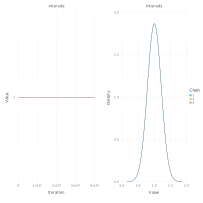

In [123]:
p3 = Mamba.plot(sim3[:, [:intervals], :], legend = true)
Mamba.draw(p3, nrow = 1, ncol = 2)

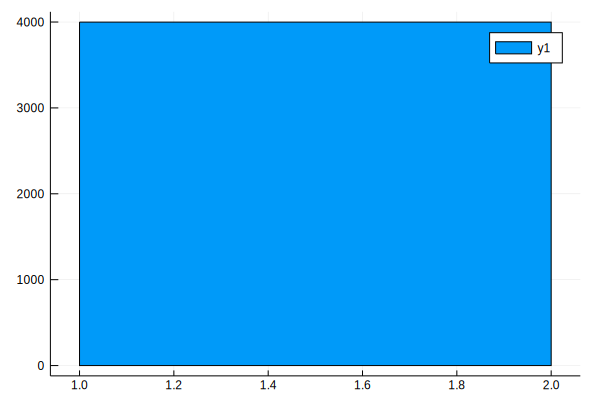

In [122]:
histogram(vec(sim3[:, [:intervals], :].value))